# 2 Layer RNN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].reshape(-1, 1), self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,1.029173,1.027691,0.995366,0.963132,0.950546,0.939012,0.931258,0.930253,0.936819,0.969631,...,0.602991,0.609653,0.616136,0.634936,0.635183,0.611303,0.636886,0.636026,non-infectious diseases,1
1,0.115685,0.113793,0.087467,0.043986,0.025690,0.007213,-0.008317,-0.006130,-0.006463,0.016679,...,-0.482568,-0.491426,-0.496198,-0.499451,-0.525215,-0.539592,-0.499635,-0.516595,non-tubercular bacterial infection,2
2,1.472517,1.480571,1.454816,1.438208,1.438841,1.441592,1.449012,1.457462,1.479481,1.529819,...,1.301975,1.312467,1.320492,1.348091,1.359999,1.326109,1.339310,1.345464,non-infectious diseases,1
3,-1.996236,-1.949873,-1.914924,-1.936027,-1.920248,-1.907690,-1.894225,-1.841829,-1.812558,-1.765338,...,-1.641571,-1.645675,-1.641252,-1.646340,-1.677596,-1.662420,-1.589074,-1.602320,non-tubercular bacterial infection,2
4,-0.430636,-0.427006,-0.444264,-0.488956,-0.505357,-0.522778,-0.537843,-0.529177,-0.528838,-0.506664,...,-0.448753,-0.445761,-0.438680,-0.429271,-0.441727,-0.445264,-0.395176,-0.399255,tuberculosis,3


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 4
NUM_LAYERS = 2
SEQ_LENGTH = 1440

In [12]:
class Model(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, num_layers=NUM_LAYERS):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.to(DEVICE)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

In [13]:
sample_x, sample_y = next(iter(train_loader))
sample_x.shape

torch.Size([8, 1440, 1])

## SGD

In [14]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [15]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─RNN: 1-1                               [8, 1440, 64]             12,608
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 12,868
Trainable params: 12,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 145.25
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.05
Estimated Total Size (MB): 6.00

In [16]:
tb_board = RUNS_PATH + "rnn_2_layer_sgd"
writer = SummaryWriter(tb_board)

In [17]:
writer.add_graph(model, sample_x)

In [18]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [20]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.38751224676768 - Accuracy: 0.21739130434782608 - Precision: 0.04725897920604915 - Recall: 0.21739130434782608 - F1: 0.07763975155279501
Epoch: 2 - Loss: 1.3869329611460368 - Accuracy: 0.21739130434782608 - Precision: 0.04725897920604915 - Recall: 0.21739130434782608 - F1: 0.07763975155279501
Epoch: 3 - Loss: 1.3869704882303873 - Accuracy: 0.21739130434782608 - Precision: 0.18095421315890728 - Recall: 0.21739130434782608 - F1: 0.09195165263218194
Epoch: 4 - Loss: 1.3867987632751464 - Accuracy: 0.23478260869565218 - Precision: 0.20916996047430828 - Recall: 0.23478260869565218 - F1: 0.1222222222222222
Epoch: 5 - Loss: 1.3860379934310914 - Accuracy: 0.22608695652173913 - Precision: 0.18065416832867973 - Recall: 0.22608695652173913 - F1: 0.11834014416752899
Epoch: 6 - Loss: 1.385242017110189 - Accuracy: 0.23478260869565218 - Precision: 0.12734743739241491 - Recall: 0.23478260869565218 - F1: 0.14812058256585994
Epoch: 7 - Loss: 1.3853804190953574 - Accuracy: 0.278260869565

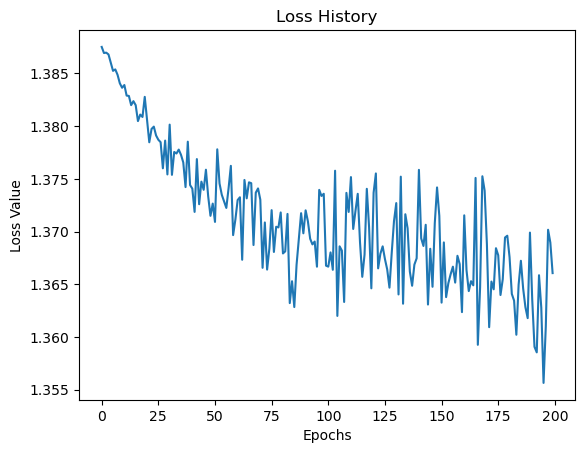

In [22]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_2_layer_rnn.pdf", bbox_inches="tight")
plt.show()

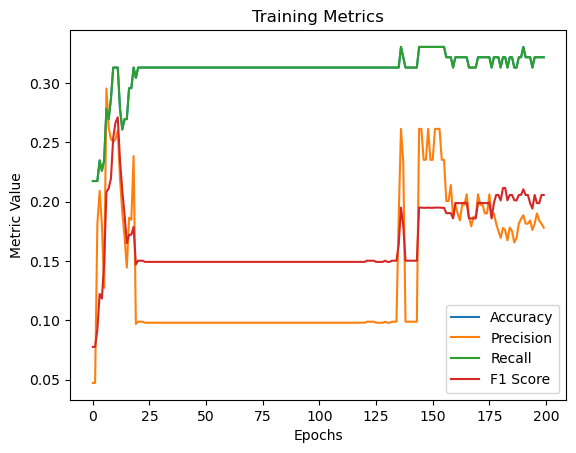

In [23]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_2_layer_rnn.pdf", bbox_inches="tight")
plt.show()

In [24]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.3114347826086956
Mean Training Precision: 0.13772140661376678
Mean Training Recall: 0.3114347826086956
Mean Training F1 Score: 0.16627153071553186


In [25]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [26]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [27]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3528684377670288
Testing Accuracy: 0.41379310344827586
Testing Precision: 0.7701149425287356
Testing Recall: 0.41379310344827586
Testing F1 Score: 0.5340406719717065


## Adam

In [28]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [29]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─RNN: 1-1                               [8, 1440, 64]             12,608
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 12,868
Trainable params: 12,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 145.25
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.05
Estimated Total Size (MB): 6.00

In [30]:
tb_board = RUNS_PATH + "rnn_2_layer_adam"
writer = SummaryWriter(tb_board)

In [31]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [33]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3874661842981975 - Accuracy: 0.23478260869565218 - Precision: 0.18107992417293464 - Recall: 0.23478260869565218 - F1: 0.17398948877209747
Epoch: 2 - Loss: 1.3777693271636964 - Accuracy: 0.3130434782608696 - Precision: 0.09799621928166352 - Recall: 0.3130434782608696 - F1: 0.14926576446875903
Epoch: 3 - Loss: 1.377105212211609 - Accuracy: 0.25217391304347825 - Precision: 0.10756296608977063 - Recall: 0.25217391304347825 - F1: 0.13865615293407338
Epoch: 4 - Loss: 1.3788172960281373 - Accuracy: 0.3130434782608696 - Precision: 0.16699604743083002 - Recall: 0.3130434782608696 - F1: 0.16549306560027224
Epoch: 5 - Loss: 1.3821075121561686 - Accuracy: 0.3130434782608696 - Precision: 0.09799621928166352 - Recall: 0.3130434782608696 - F1: 0.14926576446875903
Epoch: 6 - Loss: 1.373540735244751 - Accuracy: 0.3130434782608696 - Precision: 0.09799621928166352 - Recall: 0.3130434782608696 - F1: 0.14926576446875903
Epoch: 7 - Loss: 1.3739341735839843 - Accuracy: 0.33043478260869563 

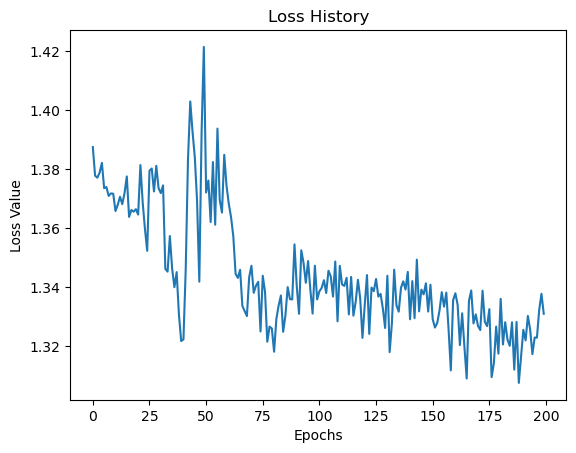

In [35]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_2_layer_rnn_adam.pdf", bbox_inches="tight")
plt.show()

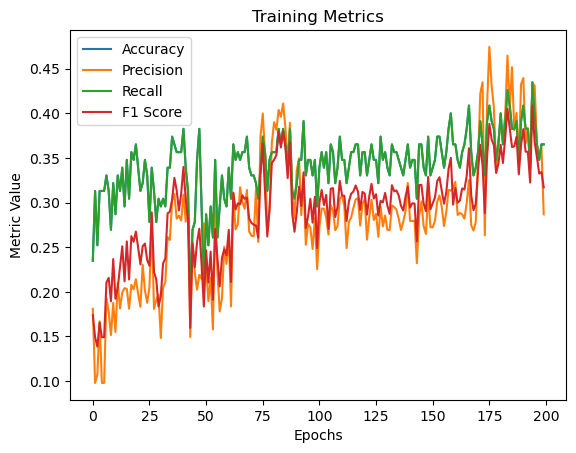

In [36]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_2_layer_rnn_adam.pdf", bbox_inches="tight")
plt.show()

In [37]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.34286956521739126
Mean Training Precision: 0.28445635124244406
Mean Training Recall: 0.34286956521739126
Mean Training F1 Score: 0.29248653264441016


In [38]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [39]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [40]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3725024461746216
Testing Accuracy: 0.27586206896551724
Testing Precision: 0.35130616509926854
Testing Recall: 0.27586206896551724
Testing F1 Score: 0.30634682658670664
